<div style="width: 100%; clear: both;">
    <div style="float: left; width: 50%;">
        <img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
    </div>
    <div style="float: right; width: 50%;">
        <p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 - Deep Learning</p>
        <p style="margin: 0; text-align:right;">Estudios de Informática, Multimedia y Telecomunicación</p>
        <p style="margin: 0; text-align:right; padding-button: 100px;">Universitat Oberta de Catalunya (UOC)</p>
    </div>
</div>
<div style="width:100%;">&nbsp;</div>

# Ejemplo de funcionamiento de Autoencoder

En este ejemplo veremos un caso de aplicación para un autoencoder. En concreto, nos centraremos en la compresión y reconstrucción de imágenes empleando *autoencoders*.

<u>Nota</u>: Este ejemplo está basado en https://blog.keras.io/building-autoencoders-in-keras.html

Deshabilitamos la aparición de warnings.

<u>Nota</u>: No se recomienda este paso cuando se está desarrollando el código.

In [1]:
import warnings

warnings.filterwarnings('ignore')

## Carga de las librerías

Carga de las librerías para ejecutar el ejemplo.

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("TensorFlow version: {}".format(tf.__version__))
print("Keras version     : {}".format(keras.__version__))
print("Numpy version     : {}".format(np.__version__))

TensorFlow version: 2.7.0
Keras version     : 2.7.0
Numpy version     : 1.21.5


In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
import matplotlib.pyplot as plt

## 1. Carga del conjunto de datos

En primer lugar, cargamos el conjunto de datos, que en este caso será el dataset de dígitos [MNIST](https://en.wikipedia.org/wiki/MNIST_database). 

Realizamos esta carga, directamente, a partir de la librería [Keras](https://keras.io/).

In [4]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 2. Creación del *autoencoder*

A continuación, creamos el *autoencoder* en su forma más senzilla:
- A partir de las imágenes de entrada de de 28x28 píxeles en escala de grises, se crea una capa con 784 valores de entrada
- Creamos un **codificador** (*encoder*) con una representación de 32 neuronas
- Creamos un **decodificador** (*decoder*) que genere una salida en la misma resolución que las imágenes de entrada, es decir, 784 neuronas de salida para generar una imagen de 28x28 píxeles en escala de grises.

In [6]:
from keras.layers import Input, Dense
from keras.models import Model

# Tamaño de la representación interna del autoencoder
layer1dim = 64
layer2dim = 32
layer3dim = 64

# capa de entrada
input_img = Input(shape=(784,))
# representación interna (encoded)
h1 = Dense(layer1dim, activation='relu')(input_img)
h2 = Dense(layer2dim, activation='relu')(h1)
h3 = Dense(layer3dim, activation='relu')(h2)

# salida del autoencoder, es decir, la imagen reconstruida (decoded)
decoded = Dense(784, activation='sigmoid')(h3)

# el modelo completo de autoencoder, que apila la entrada y la salida
autoencoder = Model(input_img, decoded)

2023-03-06 16:30:33.886782: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Para finalidades didácticas, definimos el modelo `encoder` que genera la codificación interna del autoencoder, sin el proceso de decodificación.

In [7]:
# este modelo crea la representación interna
encoder = Model(input_img, h3)

encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
Total params: 54,432
Trainable params: 54,432
Non-trainable params: 0
_________________________________________________________________


De forma similar, definimos el modelo `decoder` que a partir de la representación interna (32 valores) reconstruye la imagen, es decir, aplica el proceso de decodificación.

In [8]:
# capa de entrada de la representación interna
encoded_input = Input(shape=(layer1dim,))

# obtener la última capa del autoencoder definido previamente
decoder_layer = autoencoder.layers[-1]

# creación del modelo
decoder = Model(encoded_input, decoder_layer(encoded_input))

decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_3 (Dense)             (None, 784)               50960     
                                                                 
Total params: 50,960
Trainable params: 50,960
Non-trainable params: 0
_________________________________________________________________


Finalmente, definimos el optimizador y la función de pérdida empleada para el entrenamiento del *autoencoder*.

In [9]:
autoencoder.compile(loss="binary_crossentropy",optimizer=keras.optimizers.SGD(lr=1.5))
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 784)               50960     
                                                                 
Total params: 105,392
Trainable params: 105,392
Non-trainable params: 0
_________________________________________________________________


## 3. Entrenamiento del *autoencoder*

En el siguiente fragmento de código se entrena el *autoencoder* creado anteriormente.

Los hiperparámetros para ajustar el entrenamiento, además del optimizador y función de pérdida, son:
- número de épocas del entrenamiento
- tamaño del lote

In [10]:
n_epochs = 50
n_batch_size = 256

In [11]:
mfit = autoencoder.fit(x_train, x_train,
                epochs=n_epochs,
                batch_size=n_batch_size,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.3031 - val_loss: 0.2625
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2402 - val_loss: 0.2166
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.2043 - val_loss: 0.1939
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1866 - val_loss: 0.1798
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1732 - val_loss: 0.1642
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1628 - val_loss: 0.1576
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1563 - val_loss: 0.1528
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1517 - val_loss: 0.1466
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1480 - val_loss: 0.1494
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1438 - val_loss: 0.1413

In [12]:
#Stacked Autoencoder with functional model
#encoder
inputs = keras.Input(shape=(28,28))
lr_flatten = keras.layers.Flatten()(inputs)
lr1 = keras.layers.Dense(392, activation="selu")(lr_flatten)
lr2 = keras.layers.Dense(196, activation="selu")(lr1)
#decoder
lr3 =  keras.layers.Dense(392, activation="selu")(lr2)
lr4 =  keras.layers.Dense(28 * 28, activation="sigmoid")(lr3)
outputs = keras.layers.Reshape([28, 28])(lr4)
stacked_ae = keras.models.Model(inputs,outputs)
stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))
stacked_ae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 392)               307720    
                                                                 
 dense_5 (Dense)             (None, 196)               77028     
                                                                 
 dense_6 (Dense)             (None, 392)               77224     
                                                                 
 dense_7 (Dense)             (None, 784)               308112    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0   

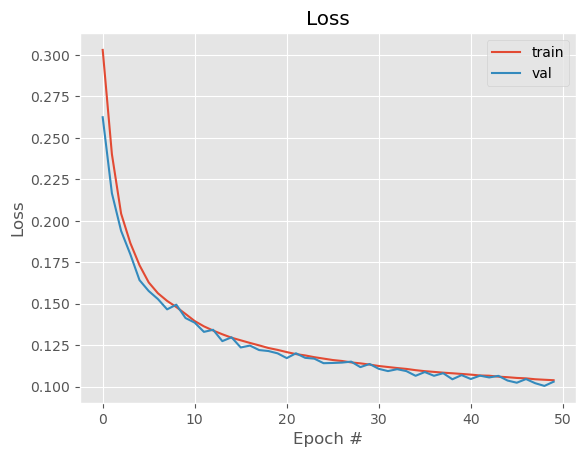

In [13]:
import matplotlib.pyplot as plt

# Plot del training loss
plt.style.use("ggplot")

plt.plot(np.arange(0, n_epochs), mfit.history["loss"], label="train")
plt.plot(np.arange(0, n_epochs), mfit.history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

## 4. Visualización de los resultados

Finalmente, presentaremos los resultados de aplicar el *autoencoder* en algunos ejemplos del conjunto de datos de test.

In [14]:
# codificamos y decodificamos las imágenes de test
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Notese que este paso se puede realizar en un solo paso, empleando:

> decoded_imgs = autoencoder.predict(x_test)

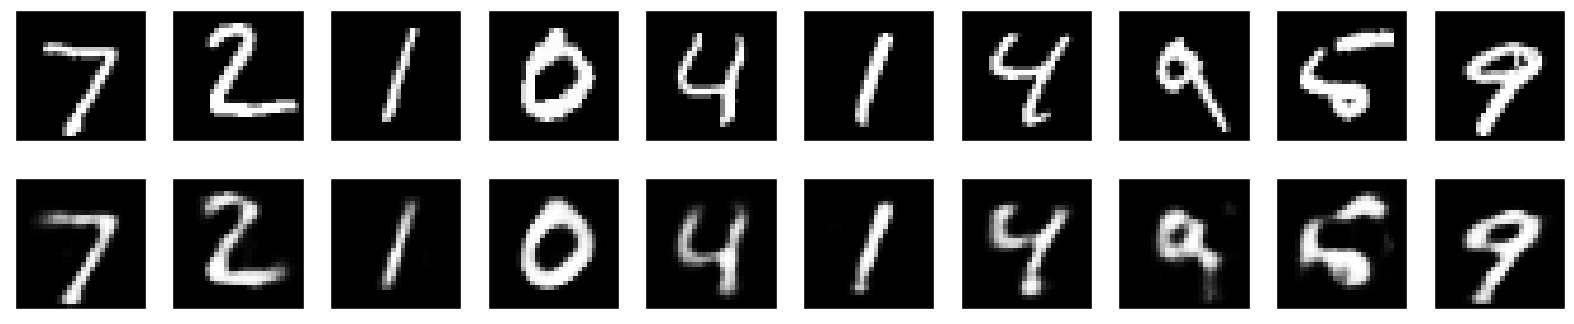

In [15]:
import matplotlib.pyplot as plt

n = 10  # cantidad de ejemplos que mostrar
plt.figure(figsize=(20, 4))

for i in range(n):
    # mostrar la imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # mostrar la reconstrucción
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()